In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.signal as ss
import h5py
import os

from analysis import plot

### Trial settings

In [2]:
setting_properties = ['duration_window', 'psd_segment_length']
settings = {
    'drifting_grating': [
        {'baseline': (.1,  .5), 'drifting_grating': (.5, 3.)}, # seconds
        {'baseline': 0.4, 'drifting_grating': 0.5} # seconds
    ],
    'movie_5s': [
        {'movie': (0.,  3.)},
        {'movie': 0.5}
    ]
}
settings = pd.DataFrame.from_dict(settings, orient='index', columns=setting_properties)
settings

,duration_window,psd_segment_length
drifting_grating,"{'baseline': (0.1, 0.5), 'drifting_grating': (...","{'baseline': 0.4, 'drifting_grating': 0.5}"
movie_5s,"{'movie': (0.0, 3.0)}",{'movie': 0.5}


#### Common parameters

In [3]:
params = dict(
    channel_id = 3, # layer 5
    fooof_params = dict(aperiodic_mode='knee', plt_range=100., freq_range=200.),
)

#### Select trial

In [4]:
trial_name = 'output_drifting'
setting_name = 'drifting_grating'

# trial_name = 'output_movie_5s'
# setting_name = 'movie_5s'

setting = settings.loc[setting_name]

### File paths

In [5]:
output_dir = os.path.join('..', 'V1_bio_outputs', trial_name)
data_dir = os.path.join('.', 'data')
trial_dir = os.path.join(data_dir, trial_name)

config_file = os.path.join(output_dir, 'config.json')
spikes_file = os.path.join(output_dir, 'spikes.h5')
ecp_file = os.path.join(output_dir, 'ecp.h5')

### Load data

In [39]:
v1_pop_df = pd.read_csv(os.path.join(data_dir, 'v1_population_properties.csv'), index_col='pop_name')

In [6]:
with h5py.File(ecp_file, 'r') as f:
    lfps = xr.DataArray(
        f['ecp']['data'][()].T,
        coords = dict(
            channel_id = f['ecp']['channel_id'][()],
            time = np.arange(*f['ecp']['time']) # ms
        ),
        attrs = dict(
            fs = 1000 / f['ecp']['time'][2] # Hz
        )
    )
display(lfps)

<xarray.DataArray (channel_id: 5, time: 30000)>
array([[4.35842737e-03, 6.93986153e-03, 8.46374209e-03, ...,
        1.07468107e-02, 1.06229797e-02, 1.03406023e-02],
       [2.50889960e-03, 3.74243531e-03, 4.48314112e-03, ...,
        1.11200801e-02, 1.08889098e-02, 1.06152263e-02],
       [9.23583039e-04, 1.55148976e-03, 2.18152849e-03, ...,
        2.74088150e-02, 2.75364814e-02, 2.74308100e-02],
       [2.33040942e-03, 4.41415163e-03, 5.95708661e-03, ...,
        6.59412979e-02, 6.61552520e-02, 6.60484159e-02],
       [4.82511713e-05, 1.48077132e-03, 3.00681768e-03, ...,
        5.51747638e-02, 5.59689128e-02, 5.65628333e-02]])
Coordinates:
  * channel_id  (channel_id) int64 0 1 2 3 4
  * time        (time) float64 0.0 0.1 0.2 0.3 0.4 ... 3e+03 3e+03 3e+03 3e+03
Attributes:
    fs:       10000.0

In [7]:
spike_file = "spike_rate.h5"

with h5py.File(os.path.join(trial_dir, spike_file), 'r') as f:
    pop_rspk = xr.DataArray(
        np.stack([g['data'] for g in f['populations'].values()], axis=0),
        coords = dict(
            population = list(f['populations'].keys()),
            time = np.arange(*f['time'])
        ),
        attrs = dict(
            fs = 1000 / f['time'][2]
        )
    ).to_dataset(name='spike_rate', promote_attrs=True)
    pop_rspk = pop_rspk.assign(
        population_number = xr.DataArray(
            [g.attrs['number'] for g in f['populations'].values()],
            coords = dict(
                population = pop_rspk.coords['population']
            )
        )
    )
display(pop_rspk)

<xarray.Dataset>
Dimensions:            (population: 34, time: 6000)
Coordinates:
  * population         (population) <U11 'LIFe23' 'LIFe4' ... 'i6Pvalb' 'i6Sst'
  * time               (time) float64 0.0 0.5 1.0 ... 2.998e+03 2.999e+03 3e+03
Data variables:
    spike_rate         (population, time) int64 0 0 0 0 0 0 0 ... 1 2 1 2 1 1 1
    population_number  (population) int64 43368 35507 25989 ... 192 1052 1059
Attributes:
    fs:       2000.0

### Plot traces

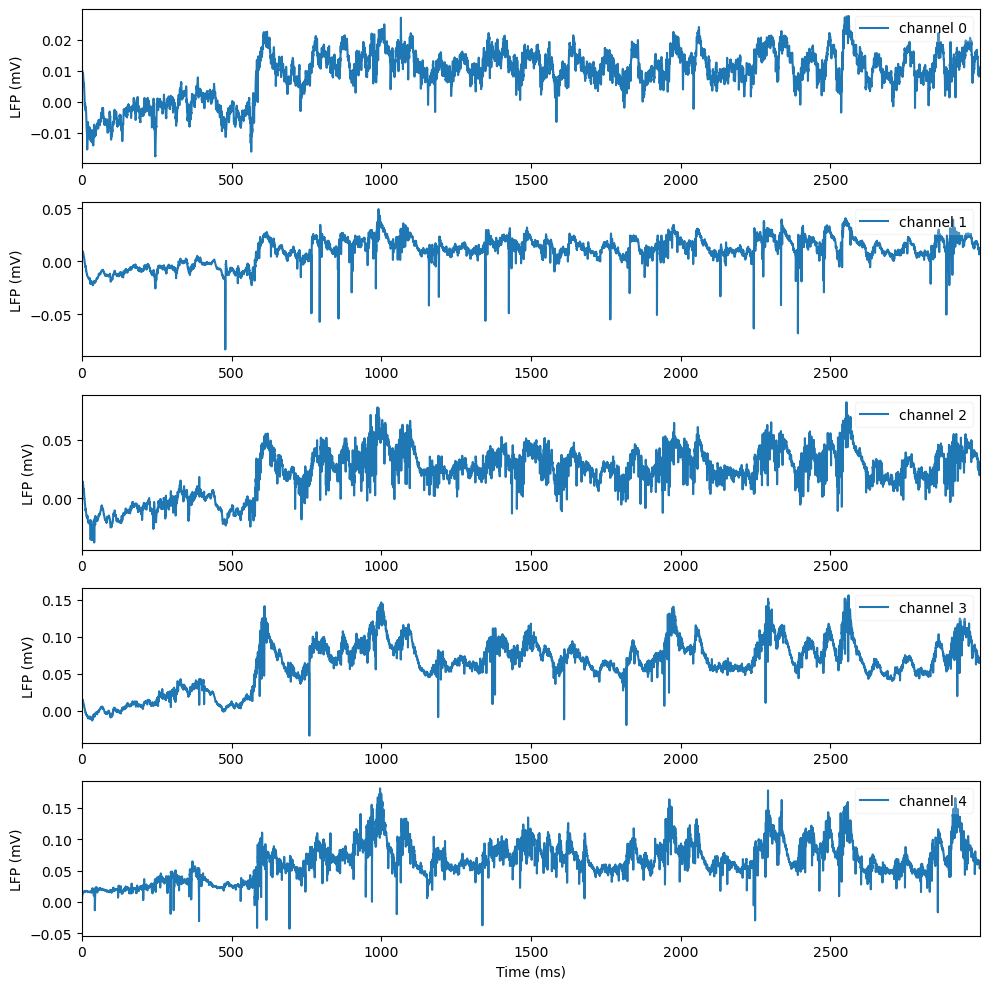

In [36]:
n_channel = lfps.coords['channel_id'].size
_, axs = plt.subplots(n_channel, 1, figsize=(10, 2 * n_channel))
for i, ax in enumerate(axs):
    ax.plot(lfps.time, lfps.isel(channel_id=i), label=f'channel {lfps.channel_id.values[i]:d}')
    ax.set_xlim(lfps.time[[0, -1]])
    ax.legend(loc='upper right', framealpha=0.2)
    ax.set_ylabel('LFP (mV)')
axs[-1].set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()


In [40]:
layers = v1_pop_df['layer'].unique()
model_types = v1_pop_df['model_type'].unique()[::-1]

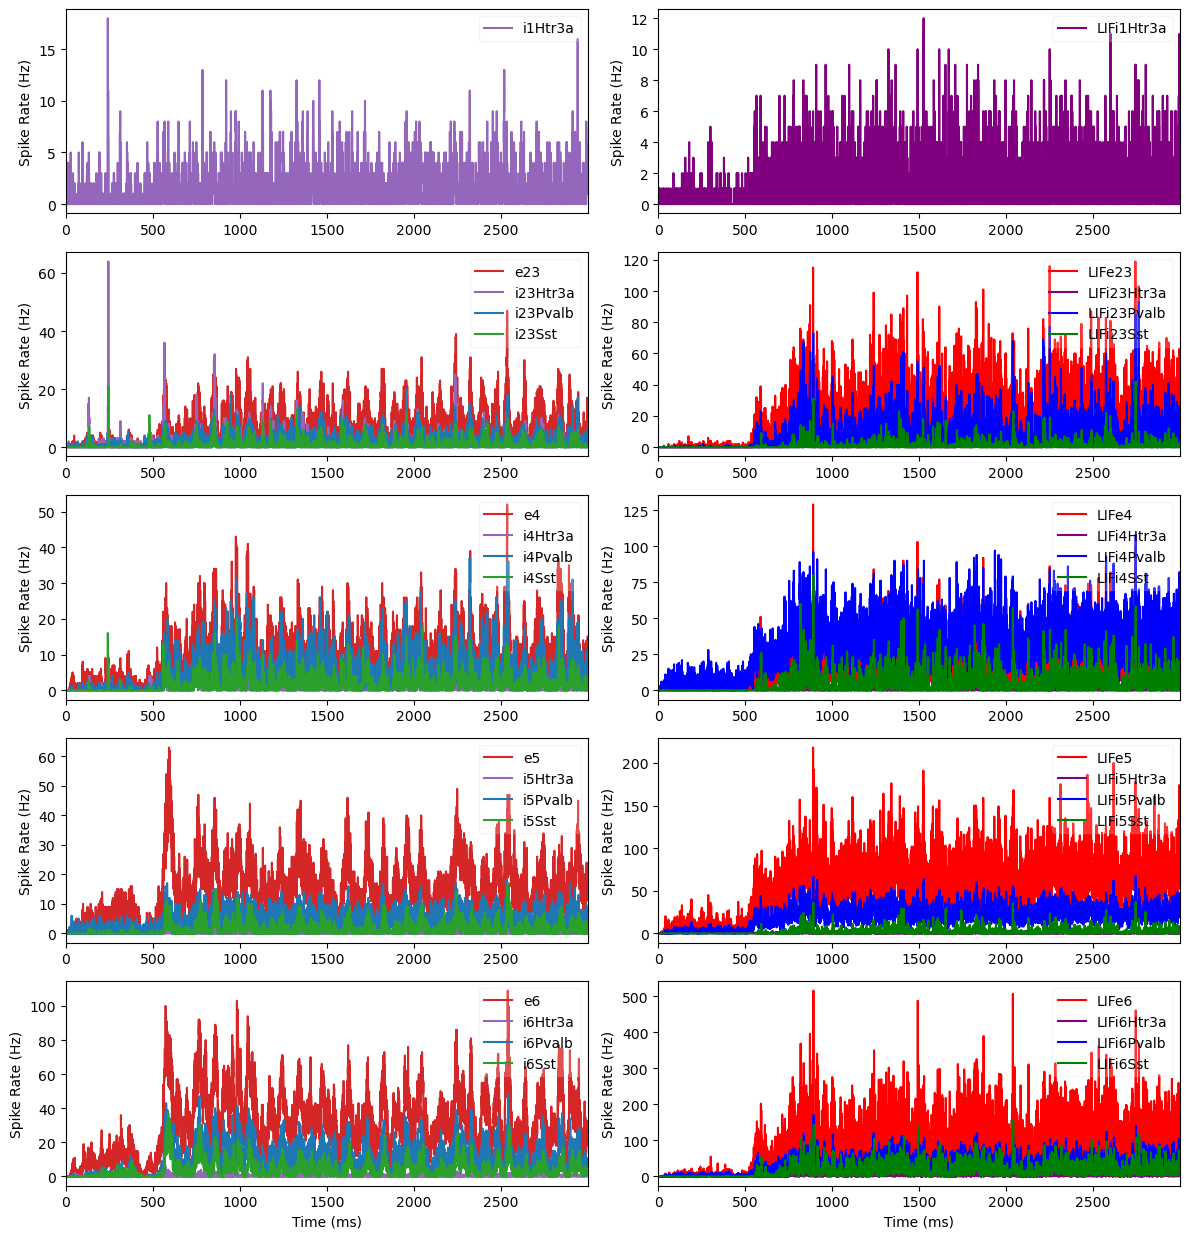

In [43]:
_, axs = plt.subplots(len(layers), 2, figsize=(12, 2.5 * len(layers)))
spike_rate = pop_rspk.spike_rate
for i, L in enumerate(layers):
    for j, M in enumerate(model_types):
        ax = axs[i, j]
        pops = v1_pop_df.index[(v1_pop_df['layer'] == L) & (v1_pop_df['model_type'] == M)]
        for p in pops:
            ax.plot(spike_rate.time, spike_rate.sel(population=p), color=v1_pop_df.loc[p, 'color'], label=p)
        ax.set_xlim(spike_rate.time[[0, -1]])
        ax.legend(loc='upper right', framealpha=0.2)
        ax.set_ylabel('Spike Rate (Hz)')
for ax in axs[-1, :]:
    ax.set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()

### PSD of LFP

baseline
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 5 - 200 Hz                        
                                 Frequency Resolution is 2.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -5.5708, -8.3381, 1.3602                                     
                                                                                                  
                                       8 peaks were found:                                        
 

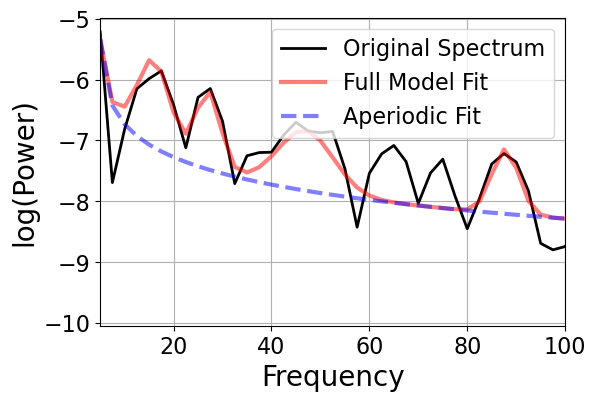

drifting_grating
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 4 - 200 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -4.5366, -5.3633, 1.4008                                     
                                                                                                  
                                       6 peaks were found:                                  

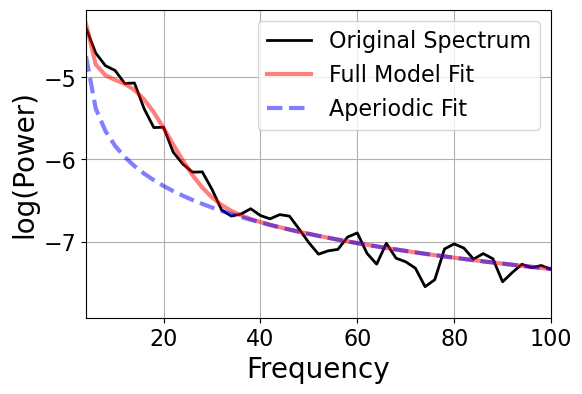

In [9]:
durations = list(setting.duration_window.keys())
fs = lfps.fs
for dur in durations:
    print(dur)
    tseg = setting.psd_segment_length[dur]
    time_window = 1000 * np.array(setting.duration_window[dur]) # ms
    f, pxx = ss.welch(lfps.sel(channel_id=params['channel_id'], time=slice(*time_window)), fs=fs, nperseg=int(tseg * fs))
    plot.fit_fooof(f, pxx, **params['fooof_params'], plot=True, report=True, figsize=(6, 4))
plt.show()

In [ ]:
# spectrogram

### PSD of spike time histogram

In [ ]:
# fs = pop_rspk.fs
# for dur in durations:
#     tseg = setting.psd_segment_length[dur]
#     time_window = 1000 * np.array(setting.duration_window[dur]) # ms
#     f, pxx = ss.welch(pop_rspk.sel(channel_id=params['channel_id'], time=slice(*time_window)), fs=fs, nperseg=int(tseg * fs))
#     plot.fit_fooof(f, pxx, params['fooof_params'], plot=True, report=True, figsize=(6, 4))
# plt.show()